In [1]:
import numpy as np
import pandas as pd

from sklearn import svm
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cirrhosis = pd.read_csv('cirrhosis.csv', header=0, sep=',')
cirrhosis.head(20)

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
5,6,2503,D,Placebo,24201,F,N,Y,N,N,0.8,248.0,3.98,50.0,944.0,93.00,63.0,NaN,11.0,3.0
6,7,1832,C,Placebo,20284,F,N,Y,N,N,1.0,322.0,4.09,52.0,824.0,60.45,213.0,204.0,9.7,3.0
7,8,2466,D,Placebo,19379,F,N,N,N,N,0.3,280.0,4.00,52.0,4651.2,28.38,189.0,373.0,11.0,3.0
8,9,2400,D,D-penicillamine,15526,F,N,N,Y,N,3.2,562.0,3.08,79.0,2276.0,144.15,88.0,251.0,11.0,2.0
9,10,51,D,Placebo,25772,F,Y,N,Y,Y,12.6,200.0,2.74,140.0,918.0,147.25,143.0,302.0,11.5,4.0


# Data Preprocessing

In [3]:
# feature dtypes:
cirrhosis.dtypes

ID                 int64
N_Days             int64
Status            object
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
dtype: object

In [4]:
cirrhosis.drop('ID', axis=1, inplace=True)
cirrhosis.drop('N_Days', axis=1, inplace=True)

In [5]:
def get_percentage_missing(series):
    """ Calculates percentage of NaN values in DataFrame
    :param series: Pandas DataFrame object
    :return: float
    """
    num = series.isnull().sum()
    den = len(series)
    return round(num/den, 2)

# Only include columns that contain any NaN values
df_with_any_null_values = cirrhosis[cirrhosis.columns[cirrhosis.isnull().any()].tolist()]

get_percentage_missing(df_with_any_null_values)

Drug             0.25
Ascites          0.25
Hepatomegaly     0.25
Spiders          0.25
Cholesterol      0.32
Copper           0.26
Alk_Phos         0.25
SGOT             0.25
Tryglicerides    0.33
Platelets        0.03
Prothrombin      0.00
Stage            0.01
dtype: float64

In [6]:
# Drop rows where target value is missing
cirrhosis=cirrhosis.dropna(subset=['Stage'])

In [7]:
# save the names of the variables with missing values (one for object and one for float columns)

df_with_any_null_values = cirrhosis[cirrhosis.columns[cirrhosis.isnull().any()].tolist()]

obj_cols = list(df_with_any_null_values.select_dtypes(include='object'))
float_cols = list(df_with_any_null_values.select_dtypes(include='float64'))

obj_cols_with_nan = get_percentage_missing(df_with_any_null_values[obj_cols]).keys()
float_cols_with_nan = get_percentage_missing(df_with_any_null_values[float_cols]).keys()

In [8]:
# explore data in categorical columns with missing values to determine how to replace the missing values

for col in obj_cols_with_nan:
    val_counts = {}
    for value in cirrhosis[col].value_counts().keys():
        val_counts[value] = cirrhosis[col].value_counts()[value]
    val_counts['NaN'] = cirrhosis[col].isna().sum()
    print('Value count for', col, ':', val_counts)

Value count for Drug : {'D-penicillamine': 158, 'Placebo': 154, 'NaN': 100}
Value count for Ascites : {'N': 288, 'Y': 24, 'NaN': 100}
Value count for Hepatomegaly : {'Y': 160, 'N': 152, 'NaN': 100}
Value count for Spiders : {'N': 222, 'Y': 90, 'NaN': 100}


In [9]:
# Drop all rows with missing values

#cirrhosis=cirrhosis.dropna()
#cirrhosis.shape

In [10]:
# First try of filling missing values

cirrhosis['Ascites'] = cirrhosis['Ascites'].fillna('N')  
#cirrhosis['Hepatomegaly'] = cirrhosis['Ascites'].fillna('Y')  
cirrhosis.drop('Hepatomegaly', axis=1, inplace=True)
cirrhosis.drop('Status', axis=1, inplace=True)
cirrhosis['Spiders'] = cirrhosis['Spiders'].fillna('N')
cirrhosis['Cholesterol'] = cirrhosis['Cholesterol'].fillna(cirrhosis['Cholesterol'].median())
cirrhosis['Copper'] = cirrhosis['Copper'].fillna(cirrhosis['Copper'].median())
cirrhosis['Alk_Phos'] = cirrhosis['Alk_Phos'].fillna(cirrhosis['Alk_Phos'].median())
cirrhosis['SGOT'] = cirrhosis['SGOT'].fillna(cirrhosis['SGOT'].median())
cirrhosis['Tryglicerides'] = cirrhosis['Tryglicerides'].fillna(cirrhosis['Tryglicerides'].median())
cirrhosis['Platelets'] = cirrhosis['Platelets'].fillna(cirrhosis['Platelets'].median())
cirrhosis['Prothrombin'] = cirrhosis['Prothrombin'].fillna(cirrhosis['Prothrombin'].median())
cirrhosis['Drug'] = cirrhosis['Drug'].fillna('No drugs')
#cirrhosis['Drug'] = cirrhosis['Drug'].fillna('D-penicillamine')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [11]:
cirrhosis['Stage']

0      4.0
1      3.0
2      4.0
3      4.0
4      3.0
      ... 
413    3.0
414    4.0
415    3.0
416    3.0
417    4.0
Name: Stage, Length: 412, dtype: float64

In [12]:
# Binary Classification
cirrhosis['Stage'] = np.where(cirrhosis['Stage'] == 4, 1, 0)
cirrhosis['Stage']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0      1
1      0
2      1
3      1
4      0
      ..
413    0
414    1
415    0
416    0
417    1
Name: Stage, Length: 412, dtype: int64

In [13]:
# Check that all missing values are gone
df_with_any_null_values = cirrhosis[cirrhosis.columns[cirrhosis.isnull().any()].tolist()]

get_percentage_missing(df_with_any_null_values)

Series([], dtype: float64)

In [14]:
# convert data to be usable in sklearn classifiers
le = LabelEncoder()
obj_cols = cirrhosis.select_dtypes(include=('object')).columns

for col in obj_cols:
    cirrhosis[col] = le.fit_transform(cirrhosis[col])

cirrhosis_y = cirrhosis.iloc[:,-1].values
cirrhosis_X = cirrhosis.iloc[:,:-1]
cirrhosis_X = cirrhosis_X.values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# SVM

In [15]:
#kfold = KFold(n_splits=5, shuffle=True)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [16]:
acc_train = []
acc_test = []

C_list = np.logspace(-5, 5, num=10, base=10)
kernel_list = ['poly', 'rbf', 'sigmoid']
param_grid = dict(C=C_list, kernel=kernel_list)
#param_grid = dict(C=C_list)

for fold, (train_ids, test_ids) in enumerate(kfold.split(cirrhosis_X, cirrhosis_y)):
    X_train, X_test = cirrhosis_X[train_ids], cirrhosis_X[test_ids]
    Y_train, Y_test = cirrhosis_y[train_ids], cirrhosis_y[test_ids]
    
    clf = GridSearchCV(svm.SVC(), param_grid=param_grid, n_jobs=-1, refit=True, cv=5)
    clf.fit(X_train, Y_train)
    
    print('Best parameters:', clf.best_params_)
    print('Train accuracy:', round(clf.score(X_train, Y_train),2))
    print('Test accuracy:', round(clf.score(X_test, Y_test),2))
    
    acc_train.append(clf.score(X_train, Y_train))
    acc_test.append(clf.score(X_test, Y_test))
final_acc_test = round(np.mean(acc_test),2)
final_acc_train = round(np.mean(acc_train),2)

print('Average train accuracy over 5 folds:', final_acc_train)
print('Average test accuracy over 5 folds:', final_acc_test)

Best parameters: {'C': 100000.0, 'kernel': 'poly'}
Train accuracy: 0.7
Test accuracy: 0.73
Best parameters: {'C': 100000.0, 'kernel': 'poly'}
Train accuracy: 0.76
Test accuracy: 0.69
Best parameters: {'C': 100000.0, 'kernel': 'poly'}
Train accuracy: 0.72
Test accuracy: 0.6
Best parameters: {'C': 599.4842503189421, 'kernel': 'poly'}
Train accuracy: 0.71
Test accuracy: 0.68
Best parameters: {'C': 100000.0, 'kernel': 'poly'}
Train accuracy: 0.74
Test accuracy: 0.67
Average train accuracy over 5 folds: 0.73
Average test accuracy over 5 folds: 0.67


(array([-10000.,  -7500.,  -5000.,  -2500.,      0.,   2500.,   5000.,
          7500.,  10000.,  12500.]),
 <a list of 10 Text major ticklabel objects>)

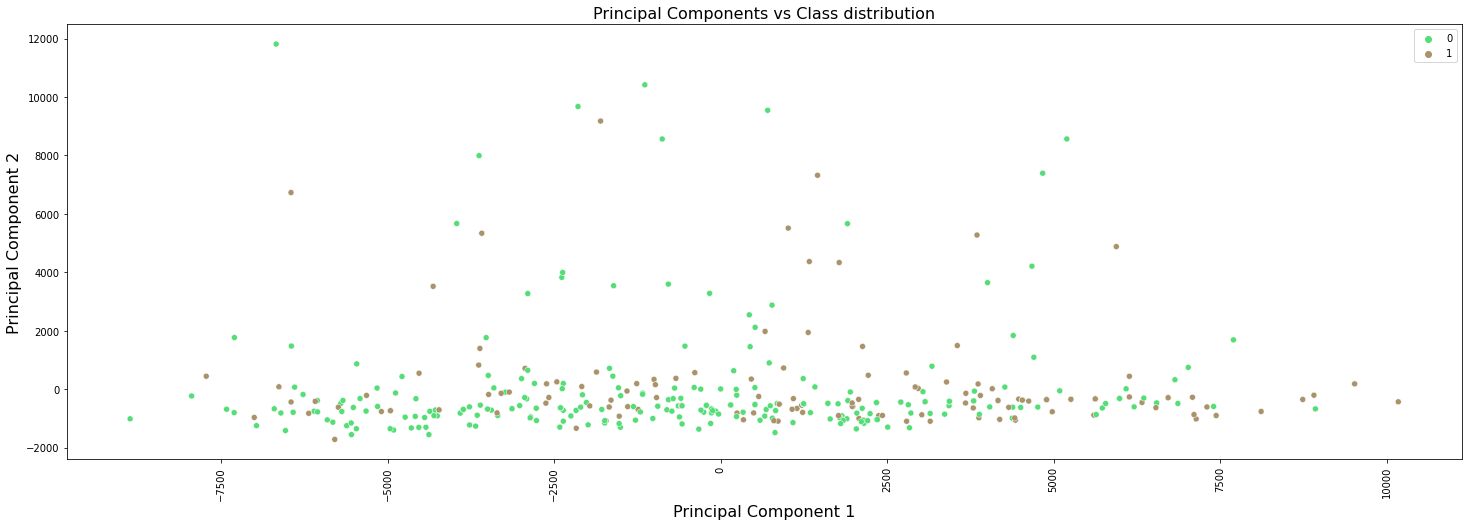

In [17]:
pca = PCA(n_components=3)
pca.fit(cirrhosis_X)
cirrhosis_X_pca = pca.transform(cirrhosis_X)

plt.figure(figsize=(25,8))
sns.scatterplot(x=cirrhosis_X_pca[:,0], y=cirrhosis_X_pca[:, 1], hue=cirrhosis_y, palette='terrain')
plt.title('Principal Components vs Class distribution', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=16)
plt.xticks(rotation='vertical')

(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8]),
 <a list of 10 Text major ticklabel objects>)

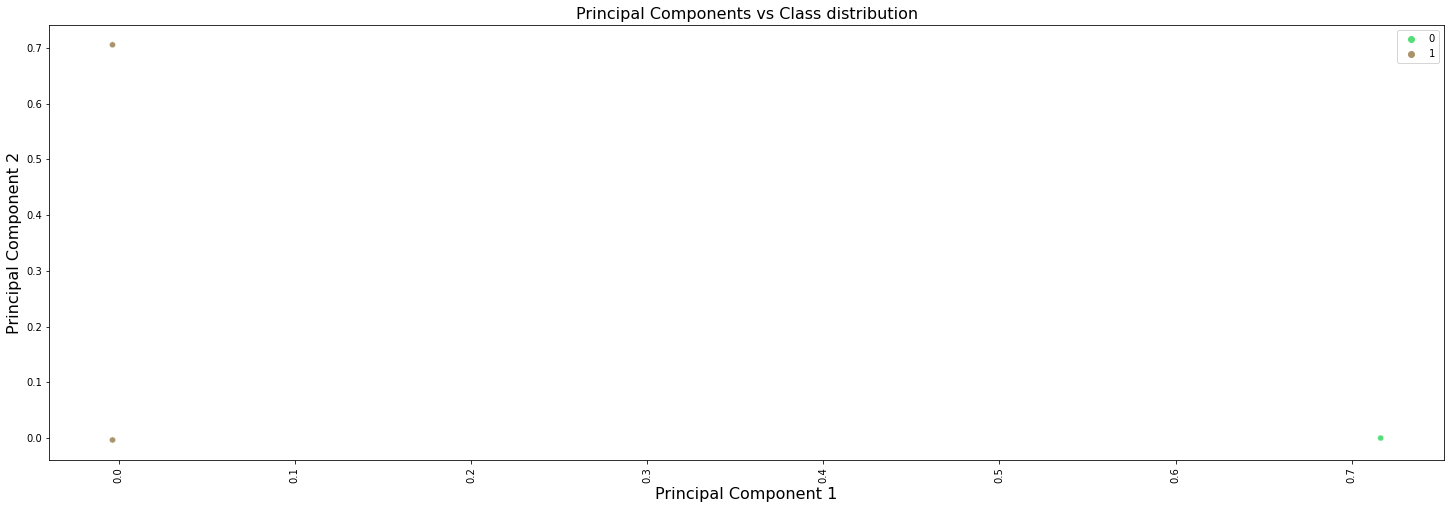

In [18]:
kernel_pca = KernelPCA(
                n_components=2, kernel='rbf', gamma=1, fit_inverse_transform=True, alpha=0.1
            )
kernel_pca.fit(cirrhosis_X)
cirrhosis_X_pca = kernel_pca.transform(cirrhosis_X)

plt.figure(figsize=(25,8))
sns.scatterplot(x=cirrhosis_X_pca[:,0], y=cirrhosis_X_pca[:, 1], hue=cirrhosis_y, palette='terrain')
plt.title('Principal Components vs Class distribution', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=16)
plt.xticks(rotation='vertical')

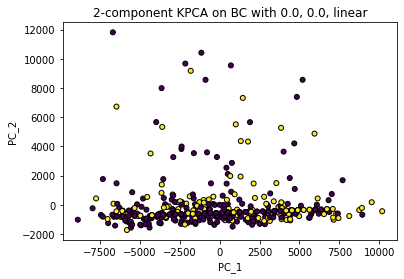

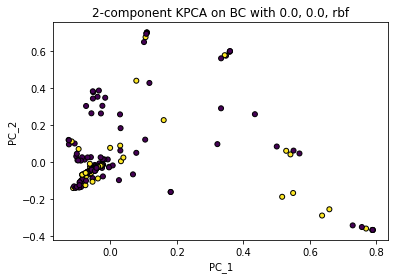

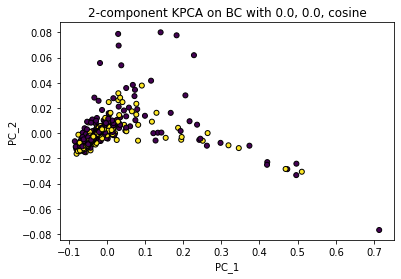

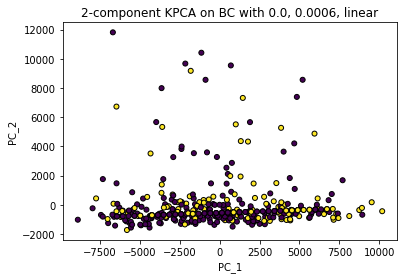

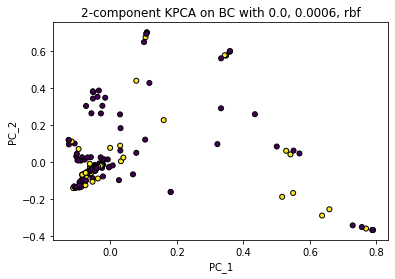

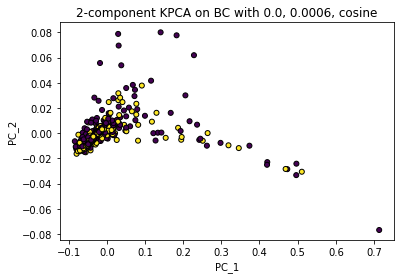

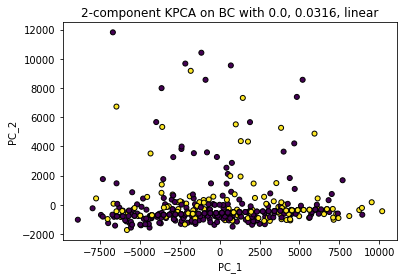

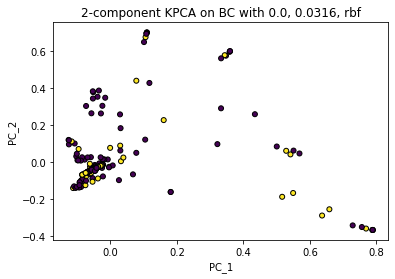

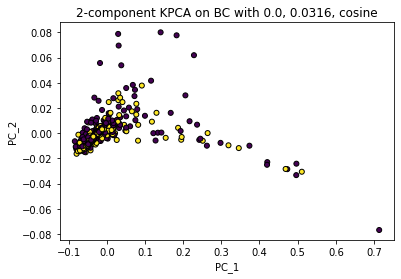

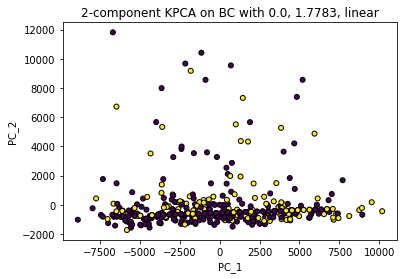

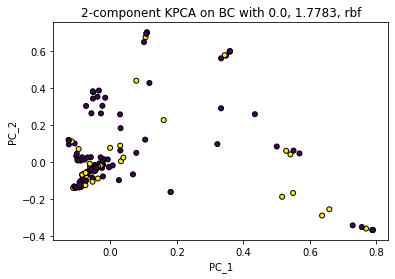

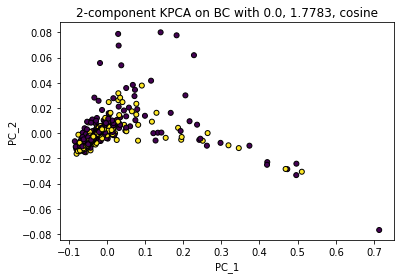

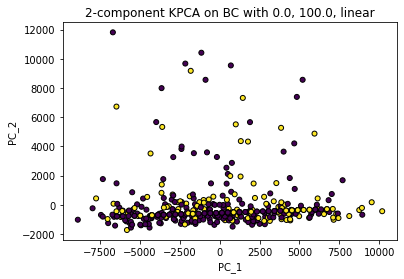

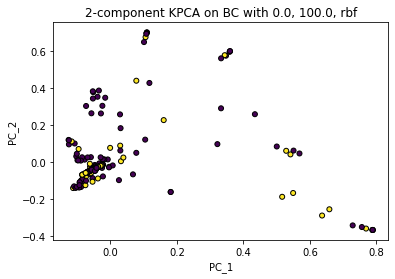

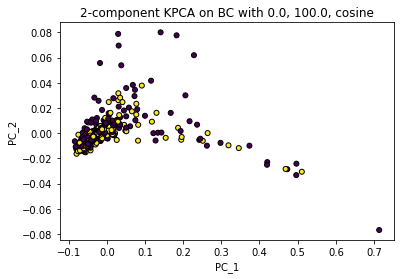

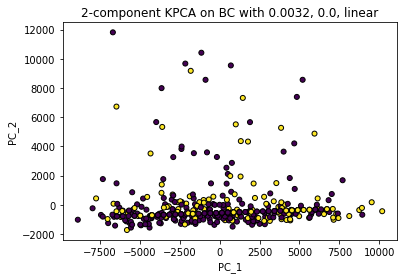

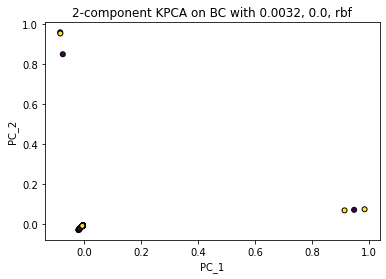

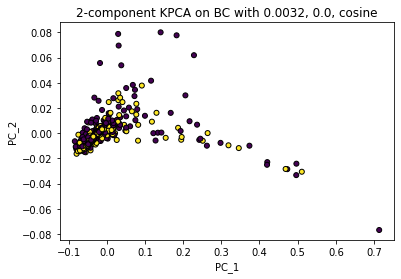

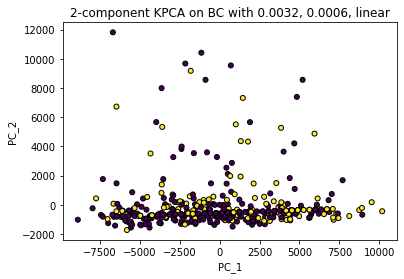

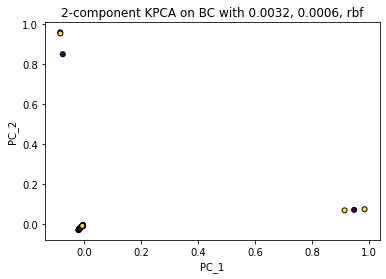

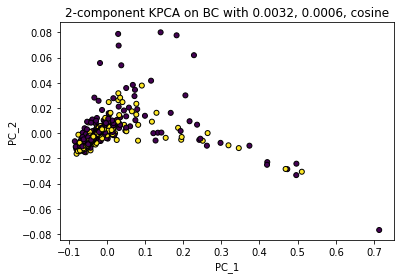

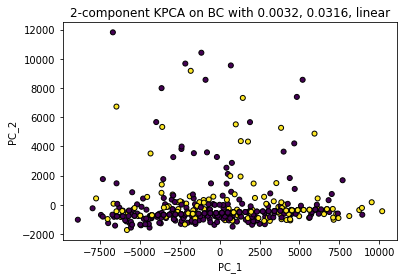

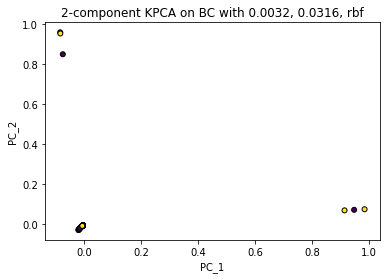

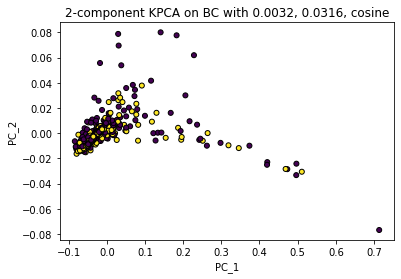

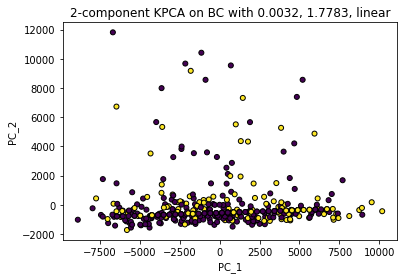

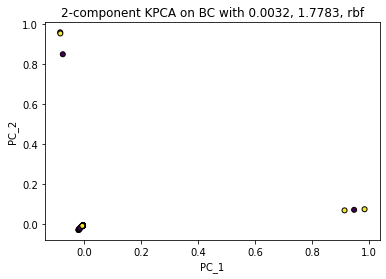

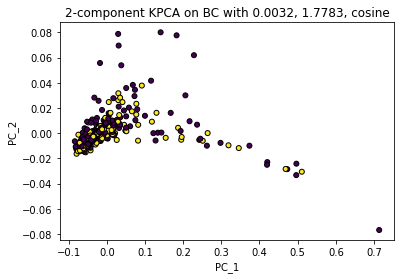

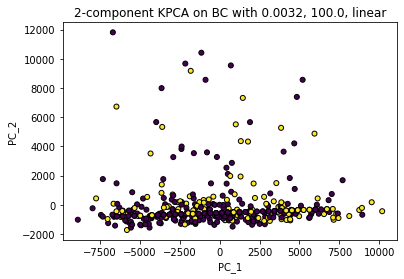

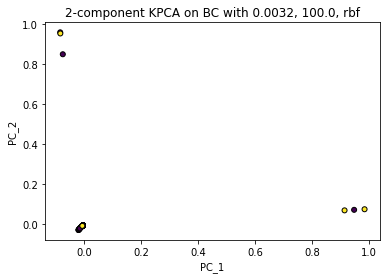

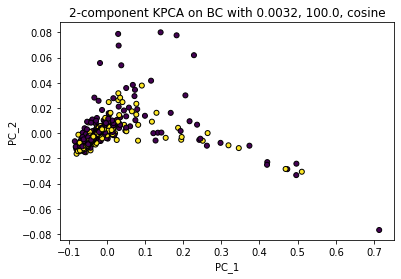

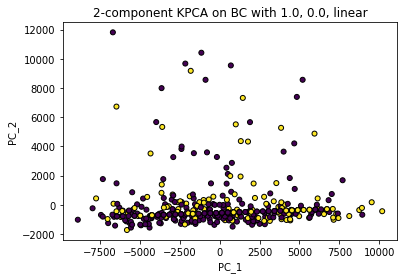

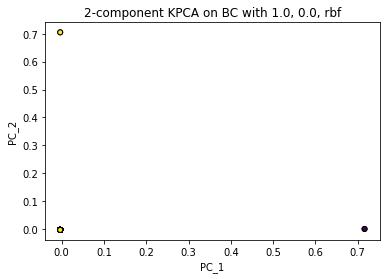

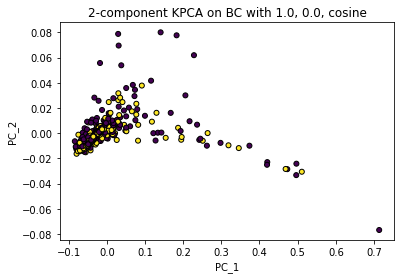

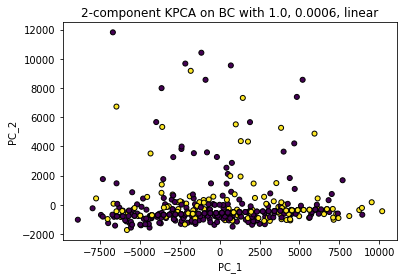

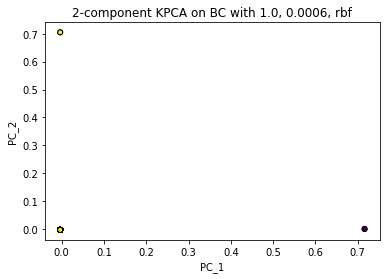

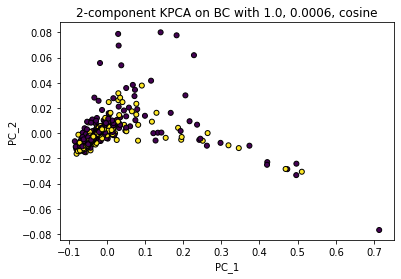

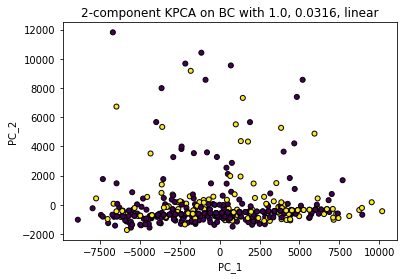

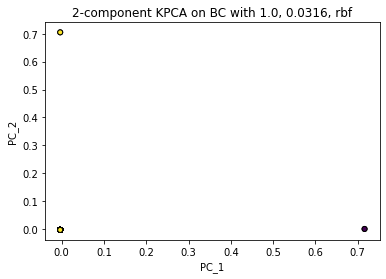

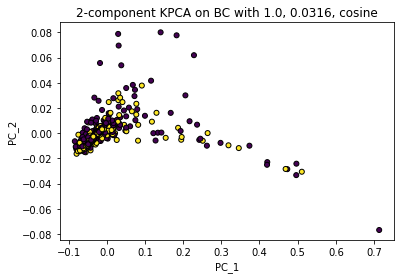

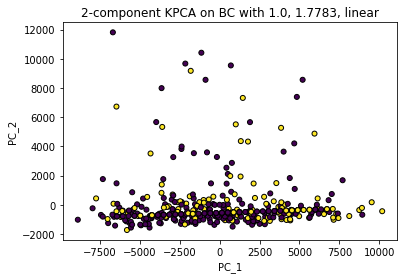

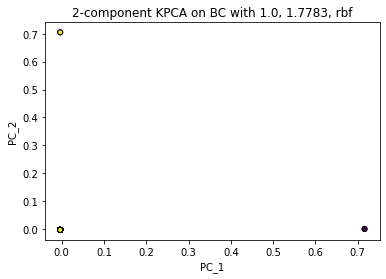

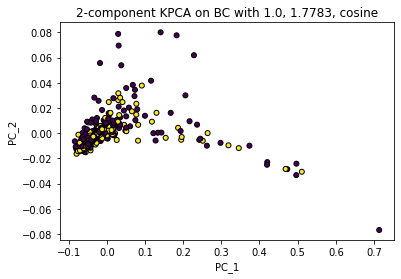

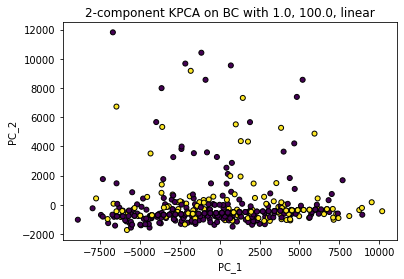

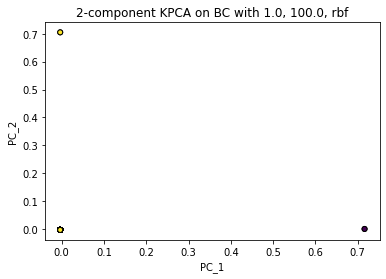

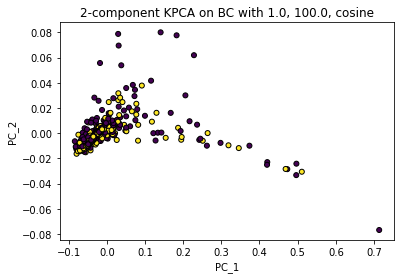

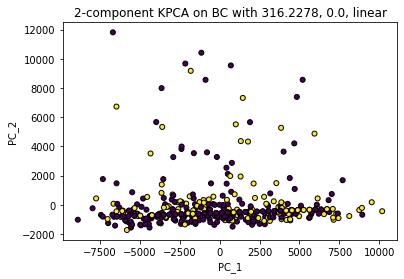

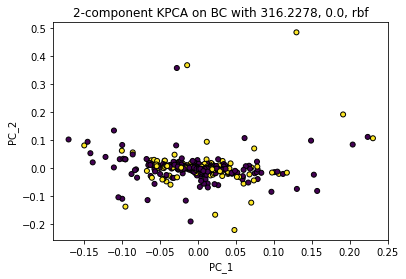

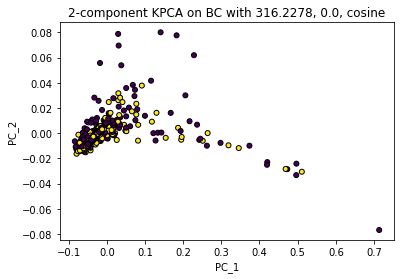

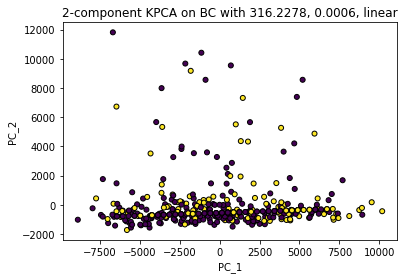

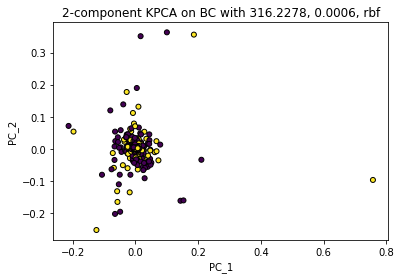

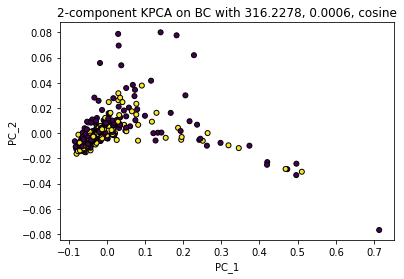

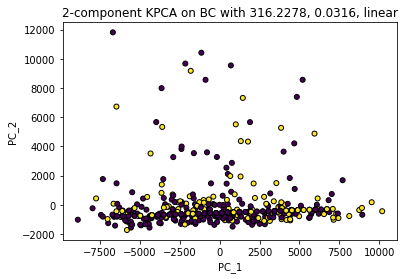

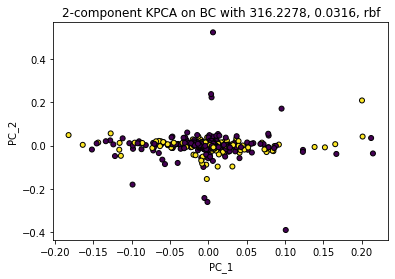

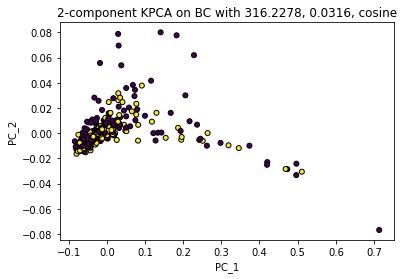

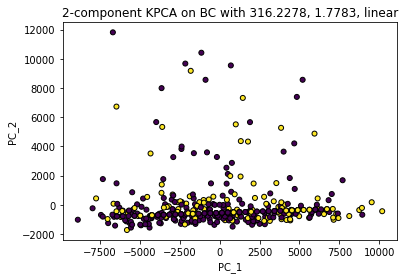

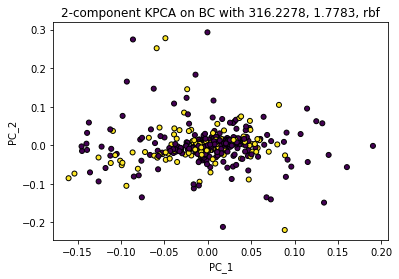

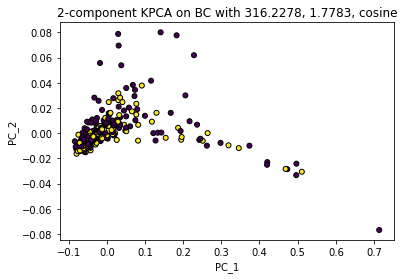

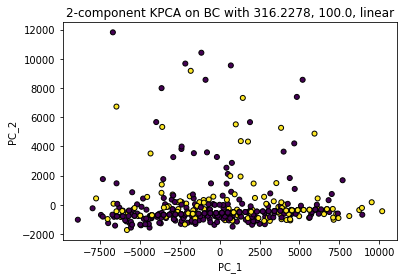

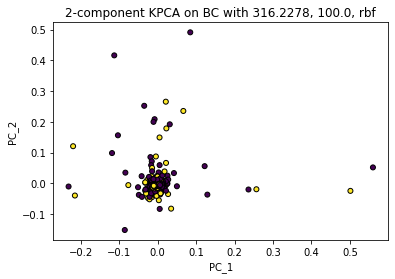

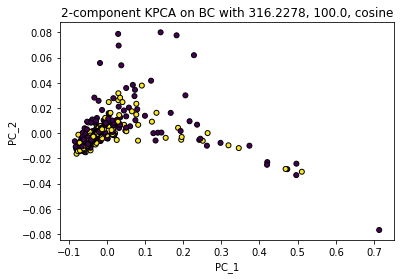

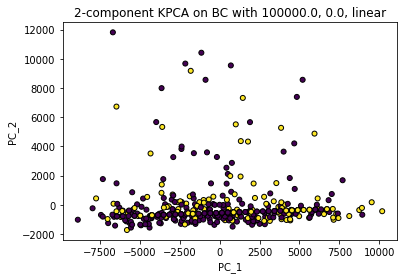

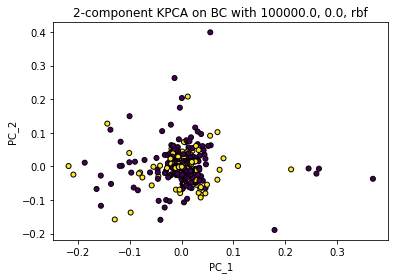

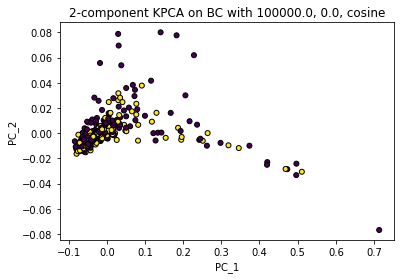

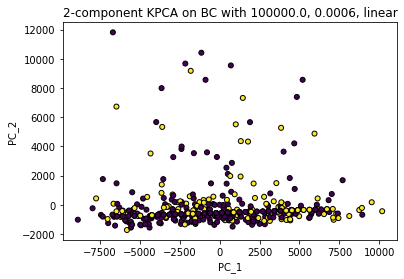

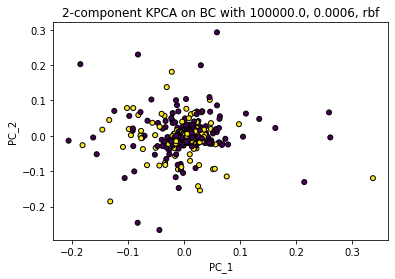

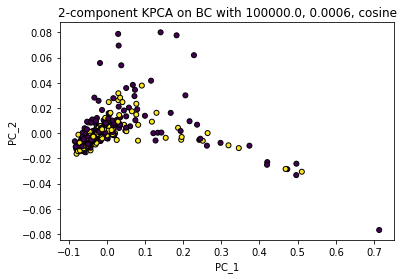

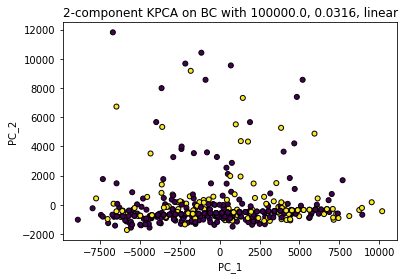

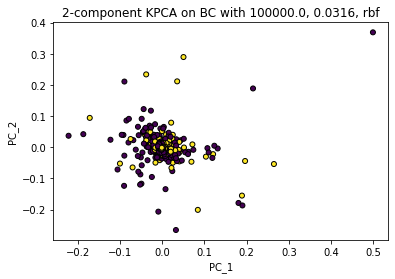

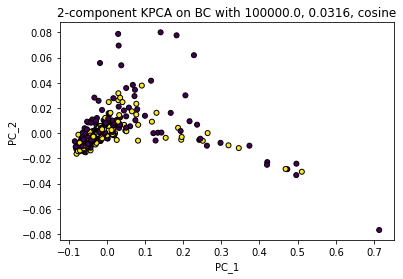

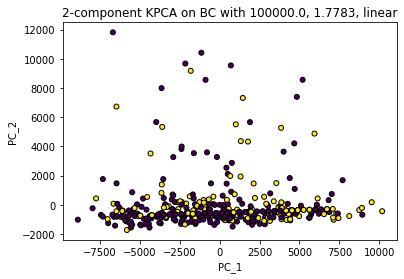

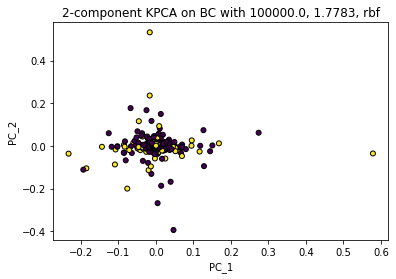

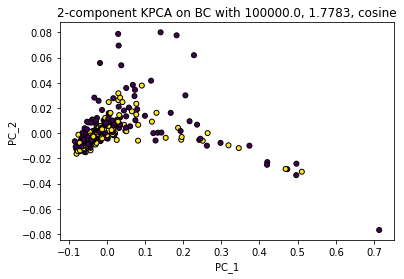

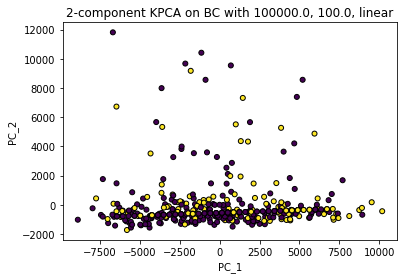

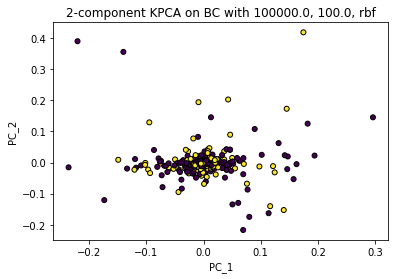

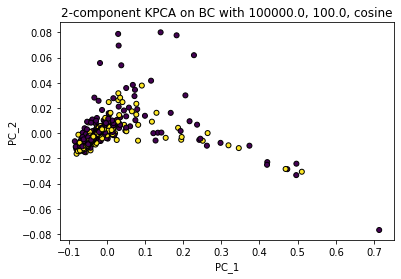

In [19]:
gamma_list = np.logspace(-5, 5, num=5, base=10)
alpha_list = np.logspace(-5, 2, num=5, base=10)
kernel_list = ['linear', 'rbf', 'cosine']

for gamma in gamma_list:
    for alpha in alpha_list:
        for kernel in kernel_list:    
            kernel_pca = KernelPCA(
                    n_components=2, kernel=kernel, gamma=gamma, fit_inverse_transform=True, alpha=alpha
                )

            kernel_pca.fit(cirrhosis_X)
            cirrhosis_X_kpca = kernel_pca.transform(cirrhosis_X)
            
            fig = plt.figure()
            plt.scatter(cirrhosis_X_kpca[:,0], cirrhosis_X_kpca[:, 1], marker='o', c=cirrhosis_y, s=25, edgecolor='k') 
            plt.title('2-component KPCA on BC with {gamma}, {alpha}, {kernel}'.format(gamma=np.round(gamma,4), alpha=np.round(alpha,4), kernel=kernel))
            plt.xlabel('PC_1')
            plt.ylabel('PC_2')
            plt.show()

In [20]:
acc_train = []
acc_test = []

for fold, (train_ids, test_ids) in enumerate(kfold.split(cirrhosis_X, cirrhosis_y)):
    X_train, X_test = cirrhosis_X[train_ids], cirrhosis_X[test_ids]
    Y_train, Y_test = cirrhosis_y[train_ids], cirrhosis_y[test_ids]

    pca = PCA(n_components=4)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    clf = svm.SVC(kernel='rbf', C=500)
    clf.fit(X_train_pca, Y_train)
    
    print('Train accuracy:', round(clf.score(X_train_pca, Y_train),2))
    print('Test accuracy:', round(clf.score(X_test_pca, Y_test),2))
    
    acc_train.append(clf.score(X_train_pca, Y_train))
    acc_test.append(clf.score(X_test_pca, Y_test))
final_acc_test = round(np.mean(acc_test),2)
final_acc_train = round(np.mean(acc_train),2)

print('Average train accuracy over 5 folds:', final_acc_train)
print('Average test accuracy over 5 folds:', final_acc_test)

Train accuracy: 0.76
Test accuracy: 0.77
Train accuracy: 0.76
Test accuracy: 0.61
Train accuracy: 0.77
Test accuracy: 0.62
Train accuracy: 0.74
Test accuracy: 0.65
Train accuracy: 0.76
Test accuracy: 0.71
Average train accuracy over 5 folds: 0.76
Average test accuracy over 5 folds: 0.67


In [21]:
acc_train = []
acc_test = []

for fold, (train_ids, test_ids) in enumerate(kfold.split(cirrhosis_X, cirrhosis_y)):
    X_train, X_test = cirrhosis_X[train_ids], cirrhosis_X[test_ids]
    Y_train, Y_test = cirrhosis_y[train_ids], cirrhosis_y[test_ids]

    kernel_pca = KernelPCA(n_components=2, kernel='cosine')
    kernel_pca.fit(X_train)
    X_train_pca = kernel_pca.transform(X_train)
    X_test_pca = kernel_pca.transform(X_test)
    
    clf = svm.SVC(kernel='rbf', C=500)
    clf.fit(X_train_pca, Y_train)
    
    print('Train accuracy:', round(clf.score(X_train_pca, Y_train),2))
    print('Test accuracy:', round(clf.score(X_test_pca, Y_test),2))
    
    acc_train.append(clf.score(X_train_pca, Y_train))
    acc_test.append(clf.score(X_test_pca, Y_test))
final_acc_test = round(np.mean(acc_test),2)
final_acc_train = round(np.mean(acc_train),2)

print('Average train accuracy over 5 folds:', final_acc_train)
print('Average test accuracy over 5 folds:', final_acc_test)

Train accuracy: 0.67
Test accuracy: 0.61
Train accuracy: 0.67
Test accuracy: 0.6
Train accuracy: 0.68
Test accuracy: 0.65
Train accuracy: 0.67
Test accuracy: 0.63
Train accuracy: 0.66
Test accuracy: 0.65
Average train accuracy over 5 folds: 0.67
Average test accuracy over 5 folds: 0.63


In [22]:
acc_train = []
acc_test = []

for fold, (train_ids, test_ids) in enumerate(kfold.split(cirrhosis_X, cirrhosis_y)):
    X_train, X_test = cirrhosis_X[train_ids], cirrhosis_X[test_ids]
    Y_train, Y_test = cirrhosis_y[train_ids], cirrhosis_y[test_ids]

    lda = LinearDiscriminantAnalysis(n_components=1)
    lda.fit(X_train, Y_train)
    X_lda_train = lda.transform(X_train)
    X_lda_test = lda.transform(X_test)
    
    clf = svm.SVC(kernel='rbf', C=10)
    clf.fit(X_lda_train, Y_train)
    
    print('Train accuracy:', round(clf.score(X_lda_train, Y_train),2))
    print('Test accuracy:', round(clf.score(X_lda_test, Y_test),2))
    
    acc_train.append(clf.score(X_lda_train, Y_train))
    acc_test.append(clf.score(X_lda_test, Y_test))
final_acc_test = round(np.mean(acc_test),2)
final_acc_train = round(np.mean(acc_train),2)

print('Average train accuracy over 5 folds:', final_acc_train)
print('Average test accuracy over 5 folds:', final_acc_test)

Train accuracy: 0.74
Test accuracy: 0.75
Train accuracy: 0.77
Test accuracy: 0.72
Train accuracy: 0.77
Test accuracy: 0.68
Train accuracy: 0.75
Test accuracy: 0.74
Train accuracy: 0.77
Test accuracy: 0.72
Average train accuracy over 5 folds: 0.76
Average test accuracy over 5 folds: 0.72


# Logistic Regression with Feature Selection

In [23]:
acc_train = []
acc_test = []

for fold, (train_ids, test_ids) in enumerate(kfold.split(cirrhosis_X, cirrhosis_y)):
    X_train, X_test = cirrhosis_X[train_ids], cirrhosis_X[test_ids]
    Y_train, Y_test = cirrhosis_y[train_ids], cirrhosis_y[test_ids]

    clf = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5, max_iter=5000)
    clf.fit(X_train, Y_train)
    
    print('Train accuracy:', round(clf.score(X_train, Y_train),2))
    print('Test accuracy:', round(clf.score(X_test, Y_test),2))
    
    acc_train.append(clf.score(X_train, Y_train))
    acc_test.append(clf.score(X_test, Y_test))
final_acc_test = round(np.mean(acc_test),2)
final_acc_train = round(np.mean(acc_train),2)

print('Average train accuracy over 5 folds:', final_acc_train)
print('Average test accuracy over 5 folds:', final_acc_test)

Train accuracy: 0.69
Test accuracy: 0.73
Train accuracy: 0.72
Test accuracy: 0.7
Train accuracy: 0.72
Test accuracy: 0.7
Train accuracy: 0.72
Test accuracy: 0.74
Train accuracy: 0.73
Test accuracy: 0.67
Average train accuracy over 5 folds: 0.72
Average test accuracy over 5 folds: 0.71


In [24]:
# try linear SVC with lasso
# try different preprocessing

# AdaBoost

In [25]:
acc_train = []
acc_test = []

n_estimator_list = [5, 10, 20, 50, 70, 100, 150, 200]
lr_list = [0.01, 0.1, 0.3, 0.5, 1, 2, 5, 10, 100]
param_grid = dict(n_estimators=n_estimator_list, learning_rate=lr_list)

for fold, (train_ids, test_ids) in enumerate(kfold.split(cirrhosis_X, cirrhosis_y)):
    X_train, X_test = cirrhosis_X[train_ids], cirrhosis_X[test_ids]
    Y_train, Y_test = cirrhosis_y[train_ids], cirrhosis_y[test_ids]
    
    clf = GridSearchCV(AdaBoostClassifier(), param_grid=param_grid, n_jobs=-1, refit=True, cv=5)
    clf.fit(X_train, Y_train)
    
    print('Best parameters:', clf.best_params_)
    print('Train accuracy:', round(clf.score(X_train, Y_train),2))
    print('Test accuracy:', round(clf.score(X_test, Y_test),2))
    
    acc_train.append(clf.score(X_train, Y_train))
    acc_test.append(clf.score(X_test, Y_test))
final_acc_test = round(np.mean(acc_test),2)
final_acc_train = round(np.mean(acc_train),2)

print('Average train accuracy over 5 folds:', final_acc_train)
print('Average test accuracy over 5 folds:', final_acc_test)

Best parameters: {'learning_rate': 0.01, 'n_estimators': 200}
Train accuracy: 0.75
Test accuracy: 0.73
Best parameters: {'learning_rate': 0.1, 'n_estimators': 50}
Train accuracy: 0.81
Test accuracy: 0.7
Best parameters: {'learning_rate': 0.1, 'n_estimators': 150}
Train accuracy: 0.85
Test accuracy: 0.7
Best parameters: {'learning_rate': 0.3, 'n_estimators': 20}
Train accuracy: 0.78
Test accuracy: 0.74
Best parameters: {'learning_rate': 0.3, 'n_estimators': 10}
Train accuracy: 0.78
Test accuracy: 0.66
Average train accuracy over 5 folds: 0.79
Average test accuracy over 5 folds: 0.71


# XGBoost

In [26]:
acc_train = []
acc_test = []

max_depth_list = [2, 3, 4, 5, 10, 15, 20, 50, 100, 200]
lr_list = [0.01, 0.1, 0.3, 0.5, 0.75, 1, 2, 5, 10, 100]

param_grid = dict(max_depth=max_depth_list, learning_rate=lr_list)

for fold, (train_ids, test_ids) in enumerate(kfold.split(cirrhosis_X, cirrhosis_y)):
    X_train, X_test = cirrhosis_X[train_ids], cirrhosis_X[test_ids]
    Y_train, Y_test = cirrhosis_y[train_ids], cirrhosis_y[test_ids]
    
    clf = GridSearchCV(XGBClassifier(), param_grid=param_grid, n_jobs=-1, refit=True, cv=5)
    clf.fit(X_train, Y_train)
    
    print('Best parameters:', clf.best_params_)
    print('Train accuracy:', round(clf.score(X_train, Y_train),2))
    print('Test accuracy:', round(clf.score(X_test, Y_test),2))
    
    acc_train.append(clf.score(X_train, Y_train))
    acc_test.append(clf.score(X_test, Y_test))
final_acc_test = round(np.mean(acc_test),2)
final_acc_train = round(np.mean(acc_train),2)

print('Average train accuracy over 5 folds:', final_acc_train)
print('Average test accuracy over 5 folds:', final_acc_test)

Best parameters: {'learning_rate': 0.1, 'max_depth': 2}
Train accuracy: 0.86
Test accuracy: 0.81
Best parameters: {'learning_rate': 0.1, 'max_depth': 2}
Train accuracy: 0.88
Test accuracy: 0.75
Best parameters: {'learning_rate': 0.3, 'max_depth': 2}
Train accuracy: 0.97
Test accuracy: 0.73
Best parameters: {'learning_rate': 0.5, 'max_depth': 2}
Train accuracy: 0.99
Test accuracy: 0.73
Best parameters: {'learning_rate': 0.1, 'max_depth': 4}
Train accuracy: 0.99
Test accuracy: 0.76
Average train accuracy over 5 folds: 0.94
Average test accuracy over 5 folds: 0.75


In [27]:
Y_test

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1])

In [28]:
clf.predict(X_test)

array([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0])

In [29]:
acc_train = []
acc_test = []

#max_depth_list = [2, 3, 4, 5, 10, 15, 20, 50, 100, 200]
#lr_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

param_grid = dict(learning_rate=lr_list)

for fold, (train_ids, test_ids) in enumerate(kfold.split(cirrhosis_X, cirrhosis_y)):
    X_train, X_test = cirrhosis_X[train_ids], cirrhosis_X[test_ids]
    Y_train, Y_test = cirrhosis_y[train_ids], cirrhosis_y[test_ids]
    
    #clf = GridSearchCV(XGBClassifier(max_depth=2), param_grid=param_grid, n_jobs=-1, refit=True, cv=5)
    clf = XGBClassifier(max_depth=2, learning_reate=0.1)
    clf.fit(X_train, Y_train)
    
    #print('Best parameters:', clf.best_params_)
    print('Train accuracy:', round(clf.score(X_train, Y_train),2))
    print('Test accuracy:', round(clf.score(X_test, Y_test),2))
    
    acc_train.append(clf.score(X_train, Y_train))
    acc_test.append(clf.score(X_test, Y_test))
final_acc_test = round(np.mean(acc_test),2)
final_acc_train = round(np.mean(acc_train),2)

print('Average train accuracy over 5 folds:', final_acc_train)
print('Average test accuracy over 5 folds:', final_acc_test)

Train accuracy: 0.86
Test accuracy: 0.81
Train accuracy: 0.88
Test accuracy: 0.75
Train accuracy: 0.88
Test accuracy: 0.74
Train accuracy: 0.88
Test accuracy: 0.77
Train accuracy: 0.88
Test accuracy: 0.74
Average train accuracy over 5 folds: 0.88
Average test accuracy over 5 folds: 0.76


In [30]:
from sklearn.neighbors import KNeighborsClassifier
acc_train = []
acc_test = []

#max_depth_list = [2, 3, 4, 5, 10, 15, 20, 50, 100, 200]
#lr_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
n_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]

param_grid = dict(n_neighbors=n_list)

for fold, (train_ids, test_ids) in enumerate(kfold.split(cirrhosis_X, cirrhosis_y)):
    X_train, X_test = cirrhosis_X[train_ids], cirrhosis_X[test_ids]
    Y_train, Y_test = cirrhosis_y[train_ids], cirrhosis_y[test_ids]
    
    clf = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, n_jobs=-1, refit=True, cv=5)
    #clf = KNeighborsClassifier(n_neighbors = 5)
    clf.fit(X_train, Y_train)
    
    print('Best parameters:', clf.best_params_)
    print('Train accuracy:', round(clf.score(X_train, Y_train),2))
    print('Test accuracy:', round(clf.score(X_test, Y_test),2))
    
    acc_train.append(clf.score(X_train, Y_train))
    acc_test.append(clf.score(X_test, Y_test))
final_acc_test = round(np.mean(acc_test),2)
final_acc_train = round(np.mean(acc_train),2)

print('Average train accuracy over 5 folds:', final_acc_train)
print('Average test accuracy over 5 folds:', final_acc_test)

Best parameters: {'n_neighbors': 4}
Train accuracy: 0.73
Test accuracy: 0.67
Best parameters: {'n_neighbors': 3}
Train accuracy: 0.81
Test accuracy: 0.55
Best parameters: {'n_neighbors': 3}
Train accuracy: 0.79
Test accuracy: 0.62
Best parameters: {'n_neighbors': 4}
Train accuracy: 0.75
Test accuracy: 0.66
Best parameters: {'n_neighbors': 7}
Train accuracy: 0.71
Test accuracy: 0.68
Average train accuracy over 5 folds: 0.76
Average test accuracy over 5 folds: 0.64
